---
# 🧠 Construire un neurone (from scratch)

Bienvenue ! On va coder un perceptron logistique pas à pas, visualiser sa frontière de décision, et comprendre ses gradients. 
Objectif: apprendre en manipulant et en voyant le modèle « vivre » pendant l’entraînement.


### 🔧 Importer les bibliothèques

On prépare NumPy, Matplotlib (pour les tracés live) ainsi que scikit‑learn pour générer des jeux de données jouets.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "axes.facecolor": "#1e1e1e",
    "figure.facecolor": "#1e1e1e",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "grid.color": "gray",
    "legend.facecolor": "#2d2d2d",
    "legend.edgecolor": "white"
})
from sklearn.datasets import *
from sklearn.metrics import accuracy_score
from tqdm import *
import plotly.graph_objects as go
from IPython.display import clear_output, display
from matplotlib.colors import ListedColormap

### 🧩 Classe neurone

On définit un neurone sigmoïde avec:
- forward (activation),
- backward (chaîne de gradient),
- mise à jour des poids,
- utilitaires pratiques (predict, loss, affichage).

In [13]:
class artificial_neuron():

    def __init__(self, n_iter = 100, learning_rate = 0.1):
        self.W_ = None
        self.b_ = None
        self.n_iter_ = n_iter
        self.learning_rate_ = learning_rate
        self.loss_ = []
        self.epsilon_ = 1e-15

        # caches pour backprop
        self._X_cache = None
        self._A_cache = None

        # gradients
        self._dW = None
        self._db = None

    # ---------- utilitaires ----------
    def _sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def _sigmoid_deriv_from_A(self, A):
        return A * (1 - A)

    # ---------- API "réseau" ----------
    def init_params(self, n_in, rng=None, scale=None):
        if rng is None:
            rng = np.random.default_rng(0)
        if scale is None:
            scale = np.sqrt(1.0 / n_in)
        self.W_ = rng.normal(0.0, 1.0, size=(n_in, 1)) * scale
        self.b_ = np.zeros(1)

    def forward(self, X):
        Z = X.dot(self.W_) + self.b_
        A = self._sigmoid(Z)
        self._X_cache = X
        self._A_cache = A
        return A  # (m,1)

    def backward(self, dA):
        X = self._X_cache
        A = self._A_cache
        m = X.shape[0]

        dZ = dA * self._sigmoid_deriv_from_A(A)        # (m,1)
        dW = (X.T @ dZ) / m                            # (n_in,1)
        db = dZ.mean(axis=0)                           # (1,)
        dA_prev = dZ @ self.W_.T                       # (m, n_in)

        self._dW = dW
        self._db = db
        return dA_prev

    def backward_output(self, y):
        """
        Backprop pour la COUCHE DE SORTIE en BCE + sigmoid:
        dZ = A - y
        """
        X = self._X_cache
        A = self._A_cache
        y = y.reshape(-1, 1)
        m = X.shape[0]

        dZ = A - y                                     # (m,1)
        dW = (X.T @ dZ) / m                            # (n_in,1)
        db = dZ.mean(axis=0)                           # (1,)
        dA_prev = dZ @ self.W_.T                       # (m, n_in)

        self._dW = dW
        self._db = db
        return dA_prev

    def update_params(self, lr=None):
        if lr is None:
            lr = self.learning_rate_
        self.W_ -= lr * self._dW
        self.b_ -= lr * self._db

    # ---------- API originale ----------
    def predict_proba(self, X):
        Z = X.dot(self.W_) + self.b_
        A = 1 / (1 + np.exp(-Z))
        return A
    
    def predict(self, X):
        A = self.predict_proba(X)
        return A >= 0.5
    
    def display_loss(self):
        plt.plot(self.loss_)
        plt.show()
    
    def log_loss(self, y, A):
        return 1 / len(y) * np.sum(-y * np.log(A + self.epsilon_) - (1 - y) * np.log(1 - A + self.epsilon_))
    
    def fit(self, X, y, plot_live=False, plot_interval=10):
        # Init poids/biais + historique
        self.W_ = np.random.randn(X.shape[1], 1)
        self.b_ = np.random.randn(1)
        self.loss_ = []

        # Prépare l'affichage live (grille + figure)
        if plot_live:
            x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx0, xx1 = np.meshgrid(
                np.linspace(x0_min, x0_max, 250),
                np.linspace(x1_min, x1_max, 250)
            )
            X_grid = np.c_[xx0.ravel(), xx1.ravel()]

            # figure à 2 sous-graphiques (même style que ton réseau)
            fig, (ax_decision, ax_loss) = plt.subplots(1, 2, figsize=(12, 5))
            cmap_fluo = ListedColormap(["#2E4349", "#3B2438"])  # mêmes couleurs de fond
            fig.patch.set_facecolor("#000000")

        # Boucle d'entraînement (descente de gradient logistique)
        m = len(y)
        for epoch in range(self.n_iter_):
            # ----- Forward
            A = self.predict_proba(X)
            loss = self.log_loss(y, A)
            self.loss_.append(loss)

            # ----- Gradients (log-loss binaire)
            dW = (X.T @ (A - y)) / m
            db = (A - y).mean(axis=0)

            # ----- Update
            self.W_ -= self.learning_rate_ * dW
            self.b_ -= self.learning_rate_ * db

            # ----- Affichage live (frontière + loss)
            if plot_live and (epoch % plot_interval == 0 or epoch == self.n_iter_ - 1):
                Z = self.predict_proba(X_grid).reshape(xx0.shape)
                clear_output(wait=True)

                # --- Graphe 1 : frontière de décision
                ax_decision.clear()
                ax_decision.contourf(xx0, xx1, (Z >= 0.5).astype(int), alpha=0.7, cmap=cmap_fluo)
                ax_decision.contour(xx0, xx1, Z, levels=[0.5], colors='#FF0000', linewidths=2.0)
                ax_decision.scatter(
                    X[:, 0], X[:, 1],
                    c=y.flatten(),
                    cmap=ListedColormap(["#00FFFF", "#FF00FF"]),
                    s=40, linewidth=1
                )
                ax_decision.set_facecolor("#000000")
                ax_decision.set_title(f"Itération {epoch+1}/{self.n_iter_} • Loss: {loss:.4f}",
                                    color="white", fontsize=12)
                ax_decision.set_xlabel("x₀", color="white")
                ax_decision.set_ylabel("x₁", color="white")
                ax_decision.tick_params(colors="white")

                # --- Graphe 2 : courbe de loss
                ax_loss.clear()
                ax_loss.plot(self.loss_, color="#00FF99", linewidth=2)
                ax_loss.set_title("Évolution de la loss", color="white", fontsize=12)
                ax_loss.set_xlabel("Itérations", color="white")
                ax_loss.set_ylabel("Log Loss", color="white")
                ax_loss.set_facecolor("#000000")
                ax_loss.tick_params(colors="white")
                ax_loss.grid(color="#444444", linestyle='--', linewidth=0.5)

                display(fig)

        # Pas de double affichage final
        if plot_live:
            plt.close(fig)

### 🚀 Démo rapide (perceptron)

Entraînons le neurone sur un dataset simple et observons la frontière de décision qui évolue au fil des itérations.

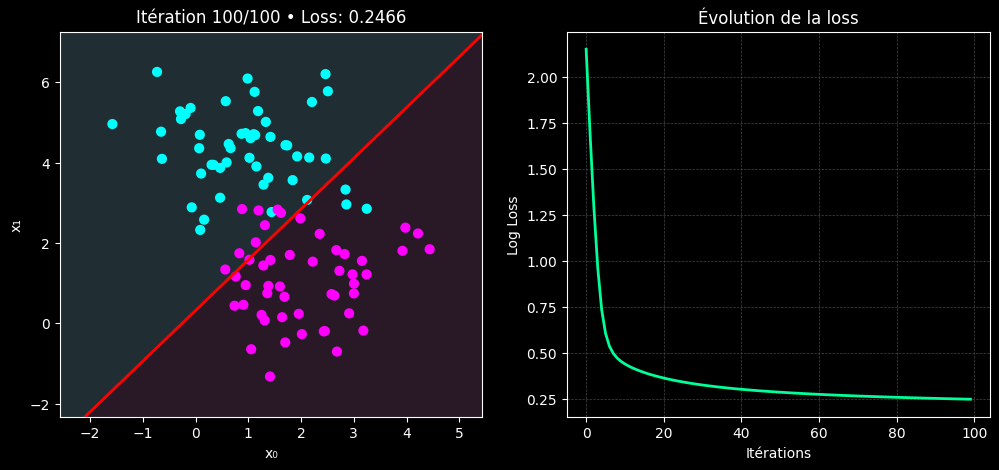

In [14]:
X, y = make_blobs(n_samples = 100, n_features = 2, centers = 2, random_state = 0)
y = y.reshape((y.shape[0], 1))

my_neuron = artificial_neuron(n_iter = 100, learning_rate = 0.1)
my_neuron.fit(X, y, plot_live=True, plot_interval=1)

### 🧪 Sigmoïde en 3D (intuitions)

Visualisons la surface de sortie A = σ(W₀x₀ + W₁x₁ + b) en 3D pour mieux comprendre la décision du neurone.

In [15]:
X0 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
X1 = np.linspace(X[:,1].min(), X[:,1].max(), 100)

xx0, xx1 = np.meshgrid(X0, X1)
Z = my_neuron.W_[0] * xx0 + my_neuron.W_[1] * xx1 + my_neuron.b_

A = 1 / (1 + np.exp(-Z))

fig = (go.Figure(data=[go.Surface(z=A, x=xx0, y=xx1, colorscale='Turbo', opacity=0.7, reversescale=True)]))
fig.add_scatter3d(x=X[:, 0].flatten(), y=X[:, 1].flatten(), z=y.flatten(),
                  mode='markers',
                  marker=dict(size=5, color=y.flatten(), colorscale='Viridis',
                              opacity=0.9, reversescale=True))

fig.update_layout(template="plotly_dark", margin=dict(l=0, r=0, b=0, t=0))
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

---
# 🧱 Du neurone au réseau (MLP)

On empile nos neurones pour former un petit MLP. But: capturer des frontières non linéaires et entraîner bout‑à‑bout (forward → backward → update) avec une BCE en sortie.

In [16]:
class neural_network():
    def __init__(self, architecture, n_iter=1000, learning_rate=0.1, seed=0):
        """
        architecture: ex [2, 3, 1]
        """
        assert len(architecture) >= 2, "architecture doit contenir au moins [n_in, n_out]"
        self.architecture_ = architecture
        self.n_iter_ = n_iter
        self.learning_rate_ = learning_rate
        self.loss_ = []
        self.layers_ = []

        # Crée les neurones (sans init des poids pour l'instant)
        for l in range(1, len(architecture)):
            n_units = architecture[l]
            layer = [artificial_neuron(n_iter=n_iter, learning_rate=learning_rate)
                     for _ in range(n_units)]
            self.layers_.append(layer)

        self._rng = np.random.default_rng(seed)

    def _init_all_weights(self, n_in_first):
        """
        Initialise les poids de tous les neurones avec la bonne taille d'entrée.
        """
        in_dim = n_in_first
        for layer in self.layers_:
            for neuron in layer:
                neuron.init_params(in_dim, rng=self._rng)
            in_dim = len(layer)

    def _forward_all(self, X):
        """
        Passe avant à travers toutes les couches.
        Retourne la dernière activation (m, 1) et les activations par couche.
        """
        A = X
        for layer in self.layers_:
            A_new_cols = []
            for neuron in layer:
                A_new_cols.append(neuron.forward(A))
            A = np.hstack(A_new_cols)
        return A

    def _bce_loss(self, y, yhat, eps=1e-15):
        y = y.reshape(-1, 1)
        yhat = np.clip(yhat, eps, 1 - eps)
        return (-(y*np.log(yhat) + (1-y)*np.log(1-yhat))).mean()

    def fit(self, X, y, plot_live=False, plot_interval=100):
        # Init
        if not self.layers_:
            raise ValueError("Pas de couches définies.")
        self._init_all_weights(X.shape[1])
        m = X.shape[0]
        y = y.reshape(-1, 1)
        assert len(self.layers_[-1]) == 1, "Pour BCE binaire, dernière couche = 1 neurone."
        self.loss_ = []

        # --- Prépare l'affichage live ---
        if plot_live:
            x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx0, xx1 = np.meshgrid(
                np.linspace(x0_min, x0_max, 250),
                np.linspace(x1_min, x1_max, 250)
            )
            X_grid = np.c_[xx0.ravel(), xx1.ravel()]

            # figure à 2 sous-graphiques
            fig, (ax_decision, ax_loss) = plt.subplots(1, 2, figsize=(12, 5))
            cmap_fluo = ListedColormap(["#2E4349", "#3B2438"])

        # Boucle d'entraînement
        for epoch in range(self.n_iter_):
            # ----- Forward
            A_last = self._forward_all(X)
            loss = self._bce_loss(y, A_last)
            self.loss_.append(loss)

            # ----- Backward sortie
            out_neuron = self.layers_[-1][0]
            dA_prev = out_neuron.backward_output(y)

            # ----- Backward couches cachées
            for layer in reversed(self.layers_[:-1]):
                m_, n_units = dA_prev.shape
                n_in_prev = layer[0]._X_cache.shape[1]
                dA_prev_next = np.zeros((m_, n_in_prev))
                for j, neuron in enumerate(layer):
                    dA_prev_next += neuron.backward(dA_prev[:, [j]])
                dA_prev = dA_prev_next

            # ----- Update
            for layer in self.layers_:
                for neuron in layer:
                    neuron.update_params(self.learning_rate_)

            # ----- Affichage live
            if plot_live and (epoch % plot_interval == 0 or epoch == self.n_iter_ - 1):
                Z = self.predict_proba(X_grid).reshape(xx0.shape)
                clear_output(wait=True)

                # ---------- Graphe 1 : frontière ----------
                ax_decision.clear()
                ax_decision.contourf(xx0, xx1, (Z >= 0.5).astype(int), alpha=0.7, cmap=cmap_fluo)
                ax_decision.contour(xx0, xx1, Z, levels=[0.5], colors='#FF0000', linewidths=2.0)
                ax_decision.scatter(X[:, 0], X[:, 1],
                                    c=y.flatten(),
                                    cmap=ListedColormap(["#00FFFF", "#FF00FF"]),
                                    s=40, linewidth=1)
                ax_decision.set_facecolor("#000000")
                ax_decision.set_title(f"Itération {epoch+1}/{self.n_iter_} • Loss: {loss:.4f}",
                                    color="white", fontsize=12)
                ax_decision.set_xlabel("x₀", color="white")
                ax_decision.set_ylabel("x₁", color="white")
                ax_decision.tick_params(colors="white")

                # ---------- Graphe 2 : loss ----------
                ax_loss.clear()
                ax_loss.plot(self.loss_, color="#00FF99", linewidth=2)
                ax_loss.set_title("Évolution de la loss", color="white", fontsize=12)
                ax_loss.set_xlabel("Itérations", color="white")
                ax_loss.set_ylabel("Log Loss", color="white")
                ax_loss.set_facecolor("#000000")
                ax_loss.tick_params(colors="white")
                ax_loss.grid(color="#444444", linestyle='--', linewidth=0.5)

                fig.patch.set_facecolor("#000000")
                display(fig)

        if plot_live:
            plt.ioff()

    def predict_proba(self, X):
        A_last = self._forward_all(X)
        return A_last

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def forward(self, X):
        return self._forward_all(X)

    def display_loss(self):
        if self.loss_:
            plt.plot(self.loss_)
            plt.title("Loss (BCE)")
            plt.xlabel("Itérations")
            plt.ylabel("Log Loss")
            plt.show()

### 🧪 Exemples de tests (MLP)

Essayons différentes géométries (lunes, cercles, XOR, etc.) et observons comment la frontière de décision s’adapte. Ajustez `architecture`, `n_iter`, `learning_rate` et amusez‑vous !

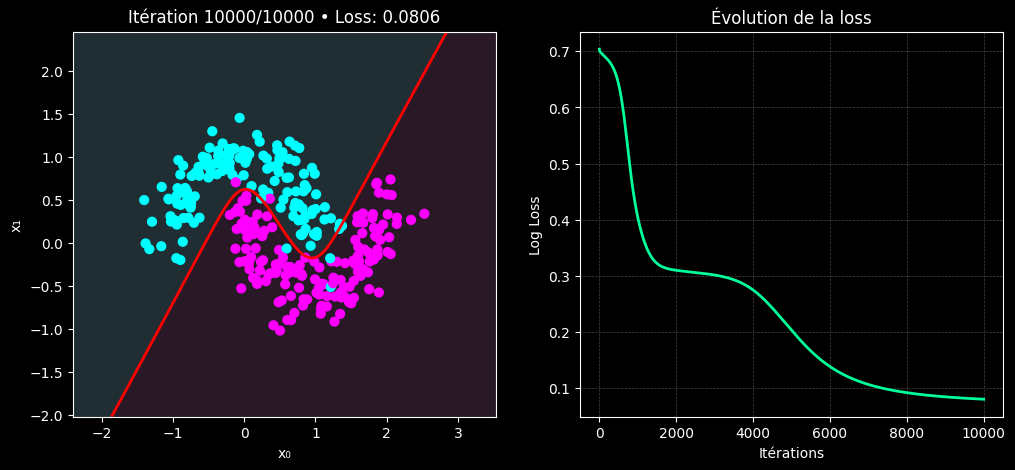

In [17]:
X, y = make_moons(n_samples=300, noise=0.2, random_state=0)
y = y.reshape(-1, 1)

my_network = neural_network(architecture=[2, 8, 8, 1], n_iter=10000, learning_rate=0.1)
my_network.fit(X, y, plot_live=True, plot_interval=100)

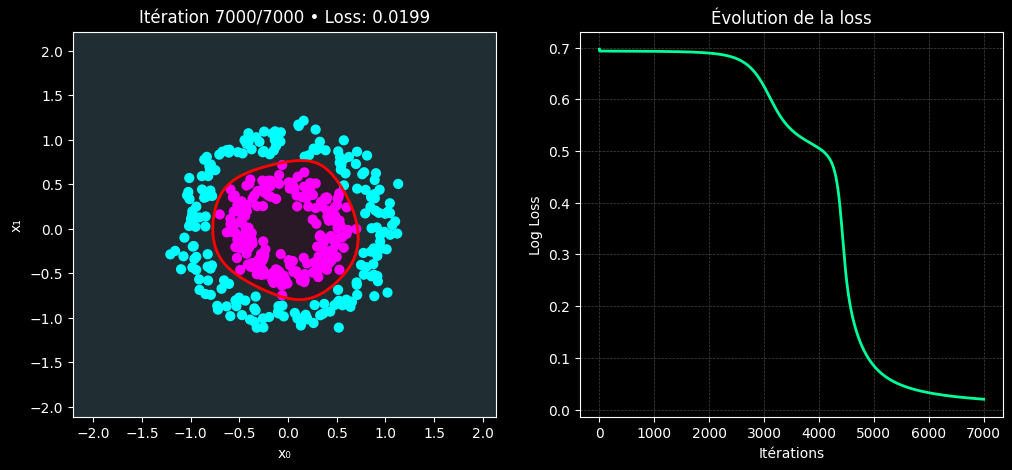

In [18]:
X, y = make_circles(n_samples=400, noise=0.1, factor=0.5, random_state=0)
y = y.reshape(-1, 1)

my_network = neural_network(architecture=[2, 8, 8, 1], n_iter=7000, learning_rate=0.3)
my_network.fit(X, y, plot_live=True, plot_interval=100)

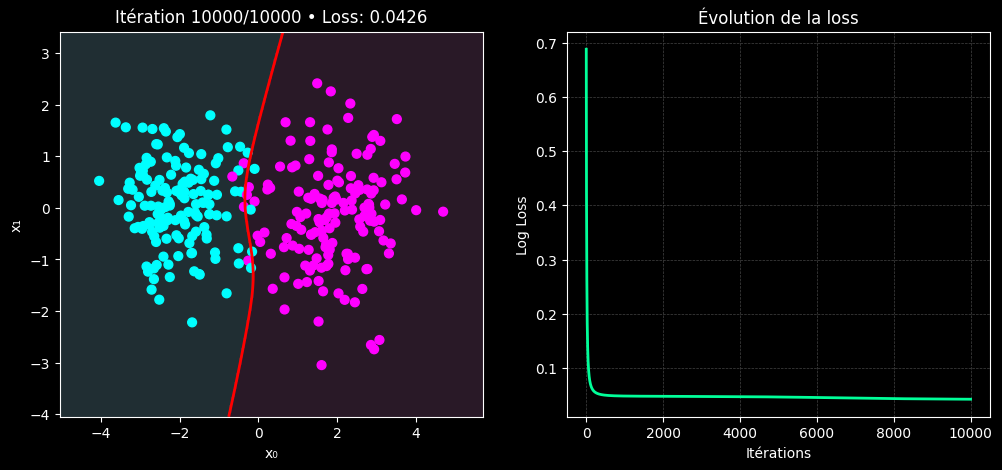

In [19]:
X, y = make_blobs(n_samples=300, centers=[[-2, 0], [2, 0]], cluster_std=[0.8, 1.0], random_state=0)

my_network = neural_network(architecture=[2, 8, 1], n_iter=10000, learning_rate=0.5)
my_network.fit(X, y, plot_live=True, plot_interval=100)

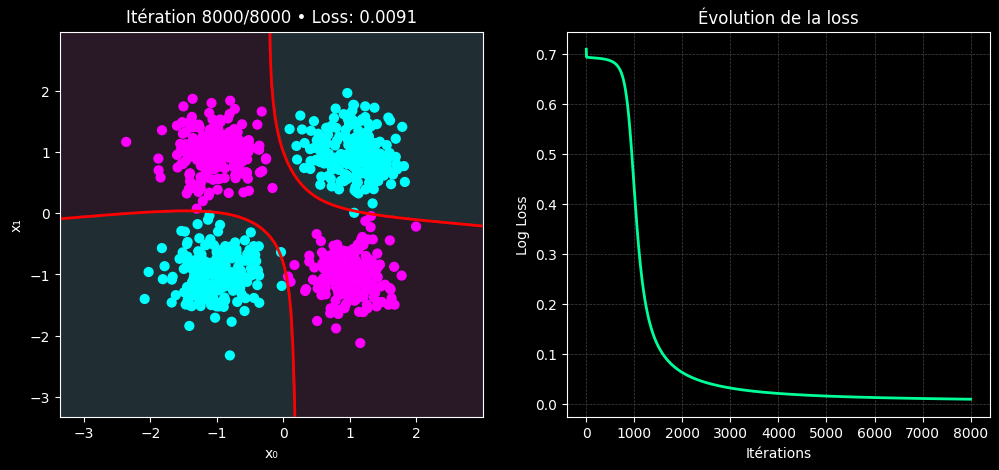

In [20]:
def make_xor(n=600, noise=0.3, seed=0):
    rng = np.random.default_rng(seed)
    # centres: (±1, ±1)
    centers = np.array([[-1,-1], [-1,1], [1,-1], [1,1]])
    X = np.vstack([c + noise * rng.standard_normal((n//4, 2)) for c in centers])
    # label = 1 si produit des signes < 0 (XOR), sinon 0
    y = (((X[:,0] > 0) ^ (X[:,1] > 0)).astype(int)).reshape(-1,1)
    return X, y

X, y = make_xor(n=800, noise=0.35, seed=0)
my_network = neural_network(architecture=[2, 16, 16, 1], n_iter=8000, learning_rate=0.2)
my_network.fit(X, y, plot_live=True, plot_interval=100)

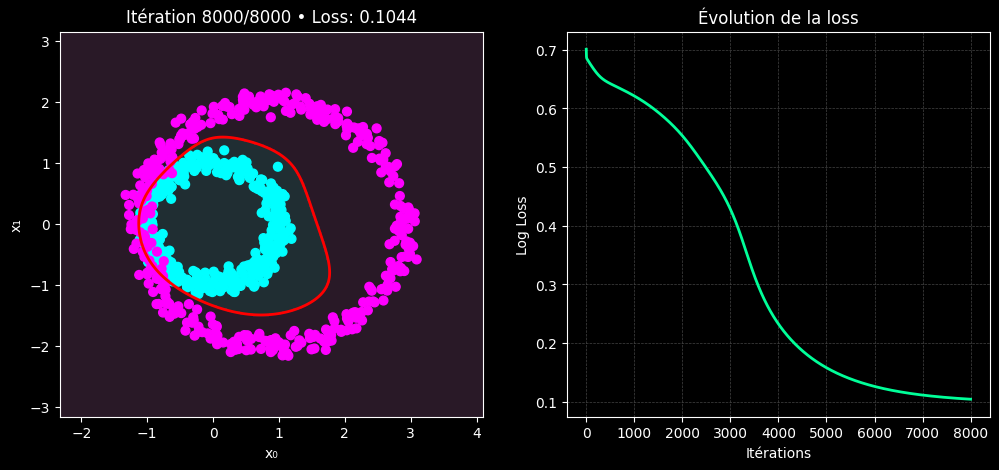

In [21]:
def make_offset_circles(n=600, r_inner=1.0, r_outer=2.0, offset=0.8, noise=0.08, seed=0):
    rng = np.random.default_rng(seed)
    m = n//2
    t1 = rng.uniform(0, 2*np.pi, m)
    t2 = rng.uniform(0, 2*np.pi, m)
    inner = np.c_[r_inner*np.cos(t1), r_inner*np.sin(t1)] + noise*rng.standard_normal((m,2))
    outer = np.c_[r_outer*np.cos(t2) + offset, r_outer*np.sin(t2)] + noise*rng.standard_normal((m,2))
    X = np.vstack([inner, outer])
    y = np.vstack([np.zeros((m,1)), np.ones((m,1))])
    return X, y

X, y = make_offset_circles(n=800, r_inner=1.0, r_outer=2.0, offset=0.9, noise=0.1, seed=0)
my_network = neural_network(architecture=[2, 16, 16, 1], n_iter=8000, learning_rate=0.15)
my_network.fit(X, y, plot_live=True, plot_interval=100)

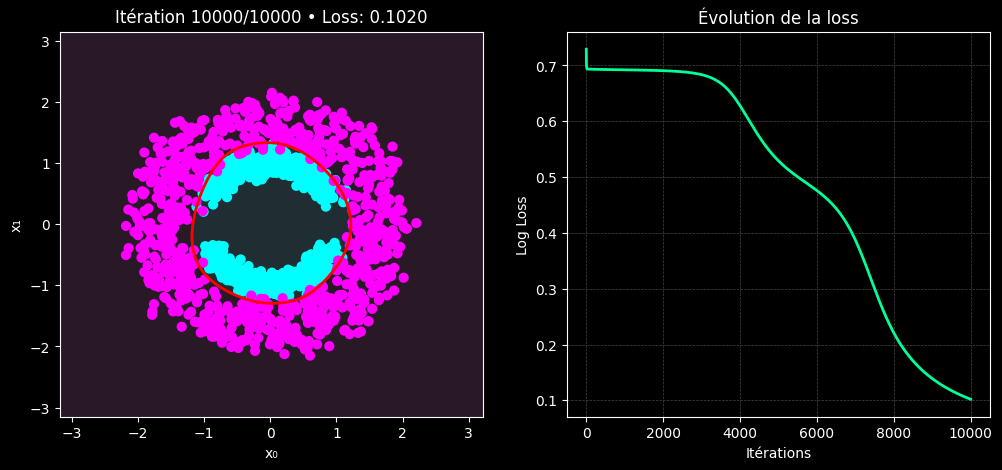

In [22]:
def make_donut_vs_arcs(n=900, r_in=1.0, r_out=2.0, noise=0.08, seed=0):
    rng = np.random.default_rng(seed)
    m = n//3

    # anneau (classe 1)
    t = rng.uniform(0, 2*np.pi, 2*m)
    rad = rng.uniform(r_in*1.3, r_out, 2*m)
    ring = np.c_[rad*np.cos(t), rad*np.sin(t)] + noise*rng.standard_normal((2*m,2))
    y_ring = np.ones((2*m,1))

    # deux arcs internes (classe 0)
    t1 = rng.uniform(-np.pi*0.85, -np.pi*0.15, m)
    t2 = rng.uniform(0.15*np.pi, 0.85*np.pi, m)
    arc1 = np.c_[(r_in*np.cos(t1)), (r_in*np.sin(t1))] + noise*rng.standard_normal((m,2))
    arc2 = np.c_[(r_in*np.cos(t2)), (r_in*np.sin(t2))] + noise*rng.standard_normal((m,2))
    arcs = np.vstack([arc1, arc2])
    y_arcs = np.zeros((2*m,1))

    X = np.vstack([arcs, ring])
    y = np.vstack([y_arcs, y_ring]).astype(int)
    return X, y

X, y = make_donut_vs_arcs(n=1200, r_in=1.0, r_out=2.1, noise=0.1, seed=0)
my_network = neural_network(architecture=[2, 32, 16, 1], n_iter=10000, learning_rate=0.1)
my_network.fit(X, y, plot_live=True, plot_interval=100)
